# Song Classification with the GTZAN Dataset

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import imageio.v3
import librosa
import librosa.display

from tqdm import trange
import optuna

import torchaudio

In [2]:
!pip install optuna

In [3]:
# only run this cell if in drive
from google.colab import drive
drive.mount('/content/drive')
#base_path = '/content/drive/MyDrive/song-classification/song-classification'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
base_path = ""

genres = os.listdir(base_path + 'Data/genres_original/')
print(genres)
genre_dict = {genres[i]: i for i in range(len(genres))}
genre_dict

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']


{'pop': 0,
 'metal': 1,
 'disco': 2,
 'blues': 3,
 'reggae': 4,
 'classical': 5,
 'rock': 6,
 'hiphop': 7,
 'country': 8,
 'jazz': 9}

In [7]:
three_sec_df = pd.read_csv(base_path + 'Data/features_3_sec.csv')

# changing dots in middle of file name to _ because it makes more sense
three_sec_df['filename'] = three_sec_df['filename'].apply(lambda x: f'{x[:-4].replace(".", "_")}.wav')
three_sec_df = three_sec_df.drop([5532, 5533, 5534, 5535, 5536, 5537, 5538, 5539, 5540, 5541]) # dropping entry that does not have spectrogram

three_sec_df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues_00000_0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues_00000_1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues_00000_2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues_00000_3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues_00000_4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,rock_00099_5.wav,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,...,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969,rock
9986,rock_00099_6.wav,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,...,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033,rock
9987,rock_00099_7.wav,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,...,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990,rock
9988,rock_00099_8.wav,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,...,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750,rock


In [ ]:
three_sec_df.loc[three_sec_df['filename'] == 'jazz_00054_0.wav'] # this file is missing from the actual data, so we need to find the index and drop it
#three_sec_df.loc[three_sec_df['filename'] == 'jazz_00054_9.wav']

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label


In [8]:
thirty_sec_df = pd.read_csv(base_path + 'Data/features_30_sec.csv')
thirty_sec_df['filename'] = thirty_sec_df['filename'].apply(lambda x: f'{x[:-4].replace(".", "_")}.wav')
thirty_sec_df = thirty_sec_df.drop([554]) # dropping entry that does not have spectrogram
thirty_sec_df


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues_00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues_00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues_00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues_00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues_00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock_00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock_00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock_00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock_00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [9]:
# Removing the "." from the middle of file names and replacing with "_" in audio folders to match the spectrogram files and also because it's really stupid to put a . in the middle of a filename
# Run this only once because otherwise it won't work if you try it again, but probably won't break anything i guess
for genre in genres:
    for song_id in os.listdir(base_path + f'Data/genres_original/{genre}'):
        #print(song_id[:-4].replace(".", ""))
        os.rename(f'Data/genres_original/{genre}/{song_id}', f'Data/genres_original/{genre}/{song_id[:-4].replace(".", "_")}.wav')

In [ ]:
print(np.max([audio[0].size()[1] for audio in audio_val])) # finding the maximum length of audio file so we can zero-pad others that are shorter to maintain consistent size

1351615


In [10]:
class AudioDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        genre_number = genre_dict[self.data.iloc[idx]['label']]
        y = [1 if i == genre_number  else 0 for i in range(len(genres))]
        x, _ = librosa.load(base_path + f'Data/genres_original/{genres[genre_number]}/{self.data.iloc[idx]["filename"][:-4]}.wav')
        #print(x.shape)
        if x.shape[0] < 675808:
            x = np.append(x, np.zeros(675808 - len(x)))
            #print(type(x[0]))
         
        return torch.Tensor(np.array([x.astype('float32')])), torch.Tensor(np.array(y).astype('float32'))
        

In [11]:
batch_size = 128

class SpectrogramDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        genre_number = genre_dict[self.data.iloc[idx]['label']]
        #print(self.data.iloc[idx]['label'])
        y = [1 if i == genre_number  else 0 for i in range(len(genres))]
        #print(genre_number)
        #print(y)
        #print(genres[y])
        image = imageio.v3.imread(base_path + f'Data/images_original/{genres[genre_number]}/{self.data.iloc[idx]["filename"][:-4].replace("_", "")}.png')
        x = torch.Tensor(image)
        x = torch.reshape(x, (4, 288, 432))
        #print(x.shape)
       
        #plt.imshow(x)
        return x, torch.Tensor(y)


In [14]:


train_set, test_set = train_test_split(thirty_sec_df, test_size = 0.2)
train_set, val_set = train_test_split(thirty_sec_df, test_size = 0.2)

audio_train = AudioDataset(train_set)
audio_val = AudioDataset(val_set)
audio_test = AudioDataset(test_set)

audio_train_dl = DataLoader(audio_train, batch_size=1)
audio_val_dl = DataLoader(audio_val, batch_size=1)
audio_test_dl = DataLoader(audio_test, batch_size=1)

spec_train = SpectrogramDataset(train_set)
spec_val = SpectrogramDataset(val_set)
spec_test = SpectrogramDataset(test_set)

spec_train_dl = DataLoader(spec_train, shuffle=True, batch_size=batch_size)
spec_val_dl = DataLoader(spec_val, shuffle=True, batch_size=batch_size)
spec_test_dl = DataLoader(spec_test, shuffle=True, batch_size=batch_size)



In [12]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


input_shape = (batch_size, 4, 288, 432)

class FeedforwardSpectrogramModel(nn.Module):

    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(4, 32, 3, stride=2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.norm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.norm2 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.norm3 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.norm4 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout()
        
        self.norm5 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2)
        self.relu3 = nn.ReLU()
        self.dropout4 = nn.Dropout()
        self.norm6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.norm7 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 1, stride=2)
        self.relu4 = nn.ReLU()
        self.dropout5 = nn.Dropout()
        self.norm8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.norm9 = nn.BatchNorm2d(256)
        self.dropout6 = nn.Dropout()
        
        
        self.conv5 = nn.Conv2d(32, 64, 3, stride=2)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2, 2)
        self.conv6 = nn.Conv2d(64, 64, 1, stride=2)
        self.relu6 = nn.ReLU()
        self.dropout3 = nn.Dropout()

        self.flatten = nn.Flatten()
        
        self.dense = nn.Linear(256, 10)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, x):
        #print('before first conv block')
        
        x = self.conv1(x)
        x = self.relu1(x)
        #x = self.dropout1(x)
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.norm2(x)
        x = self.conv2(x)
        x = self.relu2(x)
        #x = self.dropout2(x)
        x = self.norm3(x)
        x = self.pool2(x)
        x = self.norm4(x)
        x = self.dropout1(x)

        #print('before second conv block')
        x = self.norm5(x)
        x = self.conv3(x)
        x = self.relu3(x)
        #x = self.dropout4(x)
        x = self.norm6(x)
        x = self.pool3(x)
        x = self.norm7(x)
        x = self.conv4(x)
        # = self.dropout5(x)
        x = self.relu4(x)
        x = self.norm8(x)
        x = self.pool4(x)
        x = self.dropout2(x)
     
        

        
        #print('before third conv block')
        #x = self.conv5(x)
        #x = self.relu5(x)
        #x = self.pool5(x)
        #print('before conv6')
        #x = self.conv6(x)
        #x = self.pool(6)
        
        #x = self.relu6(x)
        #x = self.dropout3(x)
        
        
        x = self.flatten(x)
        x = self.dense(x)
        out = self.softmax(x)

        return out

model = FeedforwardSpectrogramModel().to(DEVICE)
print(model)

FeedforwardSpectrogramModel(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(

In [40]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []

    for i, (img, label) in enumerate(train_loader):
        #print(img)
        #print(img.shape)
        #print(label)

        #print(label.shape)
        #print(img.shape)

        #print(img)
        print(img.shape)
        img = img.to(device)
        label = label.to(device)
        # img = torch.flatten(img)
        #print((img.dtype))
        #print(img.shape)
        #print(img)
    
        optimizer.zero_grad()

        
        output = model(img)

        #print(output.shape)
        output = torch.reshape(output, (128, 1, 10))

        #print(output.shape)
        #print(label.shape)

        #criterion = nn.NLLLoss()

        #print(type(output.data.dtype))
        #print(type(label.data.dtype))

        pred = torch.Tensor([output.data.max().item()]).type(torch.LongTensor)
        label_idx = torch.Tensor([label.data.max().item()]).type(torch.LongTensor)
        #print(output)
        #print(label)
        #print(pred)
        #print(label_idx)
        #print(pred.shape)
        #print(label_idx.shape)
        
        loss = F.nll_loss(output, label)
        loss.backward()

        optimizer.step()

        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))
    
    return losses, counter

def test_one_epoch(test_loader, model, device):
    model.eval()
    accuracy = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------
            # Write your implementation here.
            
            output = model(img)
            output = torch.reshape(output, (128, 1, 10))
            

            pred = output.argmax(dim=1, keepdim=True)
            label_idx = label.argmax(dim=1, keepdim=True)
            #print(pred)
            val_correct += pred.eq(label_idx).sum().item()

            # ------------------
    accuracy = val_correct / len(test_loader)        
    #test_loss /= len(test_loader.dataset)
    return accuracy, num_correct

In [41]:
train_loader = spec_train_dl
val_loader = spec_val_dl


# Hyperparameters
lrs = [0.008]
max_epochs = 100
gamma = 0.95

# Recording data
log_interval = len(train_loader) / batch_size
def tune_model(lrs, n_epochs, train_loader=train_loader, val_loader=val_loader, gamma=gamma, type='spectrogram', num_channels=1, dilation_depth=2, num_repeat=1):
    
    model = FeedforwardSpectrogramModel().to(DEVICE)

    model = model.float()
        
    lr_dict = {}
    for lr in lrs:
        # Instantiate optimizer (model was created in previous cell)
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

        train_losses = []
        train_counter = []
        val_losses = []
        val_correct = []
        for epoch in trange(n_epochs, leave=True, desc='Epochs'):
            train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
            val_loss, num_correct = test_one_epoch(val_loader, model, DEVICE)

            # Record results
            train_losses.extend(train_loss)
            train_counter.extend(counter)
            val_losses.append(val_loss)
            val_correct.append(num_correct)

        print(f"Val accuracy: {val_correct[-1]/len(val_loader.dataset)}")
        lr_dict[lr] = train_losses, train_counter, val_losses, val_correct

results = tune_model(lrs, max_epochs,  train_loader, val_loader, num_channels=1, num_repeat=2)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-25-ab7ebffe5a10>:103: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(x)
Epochs:   0%|          | 0/100 [00:17<?, ?it/s]

torch.Size([128, 4, 288, 432])


RuntimeError: ignored

In [ ]:
def plot_losses(train_counter, train_losses, val_losses, lr):
  fig = plt.figure(figsize=(12,8))
  plt.plot(train_counter, train_losses, label='Train loss')
  #plt.plot([i * len(val_loader.dataset) for i in range(1, max_epochs + 1)], 
  #        val_losses, label='Test loss', marker='o')
  plt.xlim(left=0)
  plt.ylim(bottom=0)
  plt.title(f'Loss curve @ lr={lr}', fontsize=24)
  plt.xlabel('Number of training examples seen', fontsize=16)
  plt.ylabel('Cross Entropy Loss', fontsize=16)
  plt.legend(loc='upper right', fontsize=14)

for lr in lrs:
  print(results[lr])
  counter = results[lr][1]
  train_losses = results[lr][0]
  val_losses = results[lr][2]
  plot_losses(counter, train_losses, val_losses, lr)

NameError: name 'train_counter' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
torch.save(model, '008lr_100epochs.model')

# Spectrogram Results:

In [32]:
# in a previous run of this notebook, training the above model (with current architecture) gave us best results
# we examine its accuracy below

model = torch.load('008lr_75epochs.model')
#print(model)
num_correct = 0

for i, (img, label) in enumerate(spec_test):
    input, label = spec_test[i]
    #print(input.shape)
    input = input.reshape((1, 4, 288, 432))
    #print(input.shape)
    output = model(input)
    #print(output)
    #print(label)
    pred = output.argmax(dim=1, keepdim=True)
    #rint(pred)
    label_idx = label.argmax(dim=0, keepdim=True)
    #print(label_idx)
    #print(pred)
    #print(pred.eq(label_idx))
    num_correct += pred.eq(label_idx).sum().item()

print(num_correct)
print(len(spec_test))
print(f'spectrogram model test accuracy: {num_correct / len(spec_test)}')



/var/folders/5k/k9z7r_vs0098fm1rwf519ml40000gn/T/ipykernel_94102/1204964823.py:103: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(x)


180
200
spectrogram model test accuracy: 0.9


# Classifying the Raw Audio Files

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


class CausalConv1d(torch.nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, groups=1, bias=True):
        self.__padding = (kernel_size - 1) * dilation

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=self.__padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )


    def forward(self, input):
        #print(input.shape)
        #print(self.in_channels)
        #print(self.out_channels)
        result = super(CausalConv1d, self).forward(input)

        if self.__padding != 0:
            return result[:, :, : -self.__padding]
        return result

def _conv_stack(dilations, in_channels, out_channels, kernel_size):
    """
    Create stack of dilated convolutional layers, outlined in WaveNet paper:
    https://arxiv.org/pdf/1609.03499.pdf
    """
    return nn.ModuleList(
        [
            CausalConv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                dilation=d,
                kernel_size=kernel_size,
            )
            for i, d in enumerate(dilations)
        ]
    )

class WaveNet(nn.Module):
    def __init__(self, num_channels, dilation_depth, num_repeat, kernel_size=2):
        super(WaveNet, self).__init__()
        dilations = [2 ** d for d in range(dilation_depth)] * num_repeat
        internal_channels = int(num_channels * 2)
        self.hidden = _conv_stack(dilations, num_channels, internal_channels, kernel_size)
        self.residuals = _conv_stack(dilations, num_channels, num_channels, 1)
        self.input_layer = CausalConv1d(
            in_channels=1,
            out_channels=num_channels,
            kernel_size=1,
            groups=1,
        )

        self.linear_mix = nn.Conv1d(
            in_channels=num_channels * dilation_depth * num_repeat,
            out_channels=1,
            kernel_size=1,
        )
        self.num_channels = num_channels

        self.flatten = nn.Flatten()

        self.lastRelu = nn.ReLU()
        self.dense = nn.Linear(675808, 10)
        self.dense2 = nn.Linear(256, 10)
        self.lastRelu2 = nn.ReLU()
        self.softmax = nn.LogSoftmax()


    def forward(self, x):
        out = x
        skips = []

        #print(self.input_layer.__str__)
        
        out = self.input_layer(out)

        for hidden, residual in zip(self.hidden, self.residuals):
            x = out
            out_hidden = hidden(x)

            # gated activation
            #   split (32,16,3) into two (16,16,3) for tanh and sigm calculations
            out_hidden_split = torch.split(out_hidden, self.num_channels, dim=1)
            out = torch.tanh(out_hidden_split[0]) * torch.sigmoid(out_hidden_split[1])

            skips.append(out)

            out = residual(out)
            out = out + x[:, :, -out.size(2) :]

        # modified "postprocess" step:
        out = torch.cat([s[:, :, -out.size(2) :] for s in skips], dim=1)
        out = self.linear_mix(out)

        out = self.flatten(out)
        out = self.dense(out)
        out = self.lastRelu(out)

        #out = self.dense2(out)
        #out = self.lastRelu2(out)

        out = self.softmax(out) 
        
        return out
    
wavenet = WaveNet(num_channels=4, dilation_depth=3, num_repeat=2)
        

In [ ]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []

    for i, (img, label) in enumerate(train_loader):
        #print(img)
        #print(img.shape)
        #print(label)

        #print(label.shape)
        #print(img.shape)

        #print(img)
        
        img = img.to(device)
        label = label.to(device)
        # img = torch.flatten(img)
        #print((img.dtype))
        #print(img.shape)
        #print(img)
    
        optimizer.zero_grad()
        
        output = model(img)

        #print(output.shape)
        output = torch.reshape(output, (1, 10))
        #print(output)
        #print(label)
        #print(output.shape)
        #print(label.shape)

        pred = output.data.max(1, keepdim=True)[1]
        label_idx = label.data.max(1, keepdim=True)[1]
        #print(pred)


        criterion = nn.CrossEntropyLoss()

        loss = criterion(output, label)
        loss.backward()

        optimizer.step()

        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))
    
    return losses, counter

def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)

            # ------------------
            # Write your implementation here.
            
            output = model(img)
            output = torch.reshape(output, (1, 10))
            pred = output.data.max(1, keepdim=True)[1] # Get index of largest log-probability and use that as prediction
            
            #print(pred)
            
            label_idx = label.data.max(1, keepdim=True)[1]
            #print(pred.shape)
            #print(label_idx.shape)

            #print(label)
            num_correct += output.eq(label.data.view_as(output)).sum()
            criterion = nn.CrossEntropyLoss()
            #print(output)
            #print(label)
            #print(output.shape)
            #print(label.shape)
            test_loss += criterion(output, label)

            # ------------------
            
    #test_loss /= len(test_loader.dataset)
    return test_loss / (len(test_loader.dataset) / batch_size), num_correct

In [ ]:
train_loader = audio_val_dl
val_loader = audio_val_dl


# Hyperparameters
lrs = [.01, 0.001, .0001]
max_epochs = 2
gamma = 0.95

# Recording data
log_interval = len(train_loader) / batch_size
def tune_model(lrs, n_epochs, train_loader=train_loader, val_loader=val_loader, gamma=gamma, type='spectrogram', num_channels=1, dilation_depth=2, num_repeat=1):
    if type == 'wavenet':
        model = WaveNet(num_channels, dilation_depth, num_repeat).to(DEVICE)
    else:
        model = FeedforwardSpectrogramModel().to(DEVICE)

        model = model.float()
        
    lr_dict = {}
    for lr in lrs:
        # Instantiate optimizer (model was created in previous cell)
        optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

        train_losses = []
        train_counter = []
        val_losses = []
        val_correct = []
        for epoch in trange(n_epochs, leave=True, desc='Epochs'):
            train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
            val_loss, num_correct = test_one_epoch(val_loader, model, DEVICE)

            # Record results
            train_losses.extend(train_loss)
            train_counter.extend(counter)
            val_losses.append(val_loss)
            val_correct.append(num_correct)

        print(f"Val accuracy: {val_correct[-1]/len(val_loader.dataset)}")
        lr_dict[lr] = train_losses, train_counter, val_losses, val_correct
    return lr_dict

results = tune_model(lrs, max_epochs, type='wavenet', train_loader=audio_val_dl, val_loader=audio_val_dl, num_channels=1, num_repeat=2, dilation_depth=4)

NameError: name 'audio_val_dl' is not defined

([2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824], [3073, 6273, 9473, 12673, 15873, 19073, 22273, 25473, 3273, 6473, 9673, 12873, 16073, 19273, 22473, 25673], [tensor(294.7306), tensor(294.7306)], [tensor(0), tensor(0)])
([2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824, 2.3025851249694824], [3073, 6273, 9473, 12673, 15873, 19073, 22273, 25473, 3273, 6473, 9673, 12873, 16073, 19273, 22473, 25673], [tensor(294.7306), tensor(294.7306)], [tensor(0), tensor(0)])
([2.3025851249

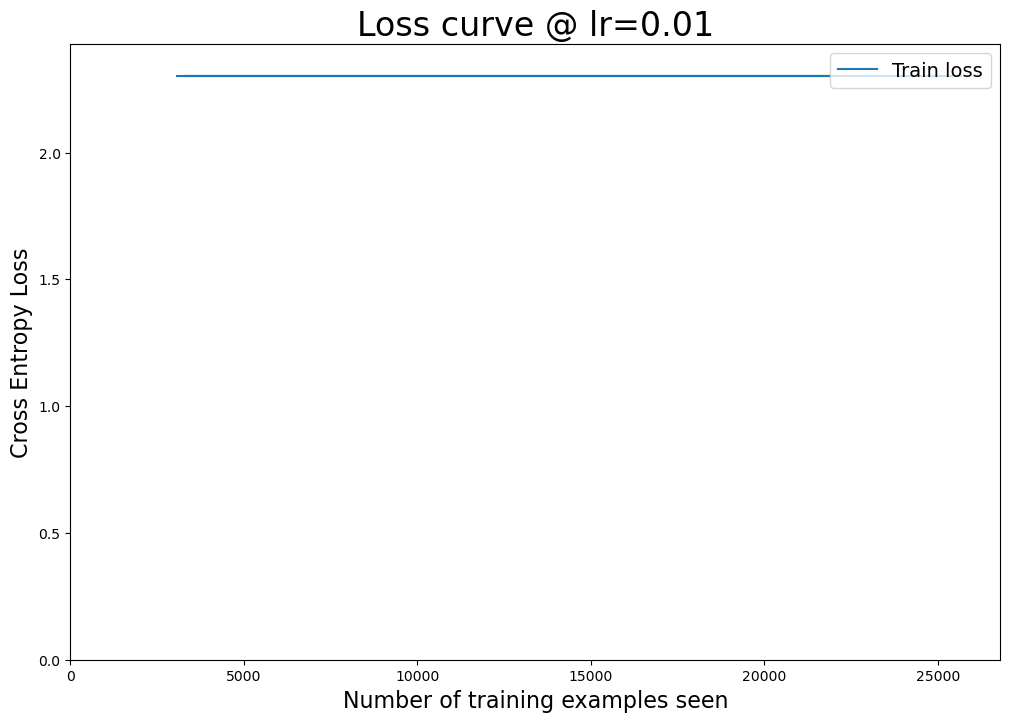

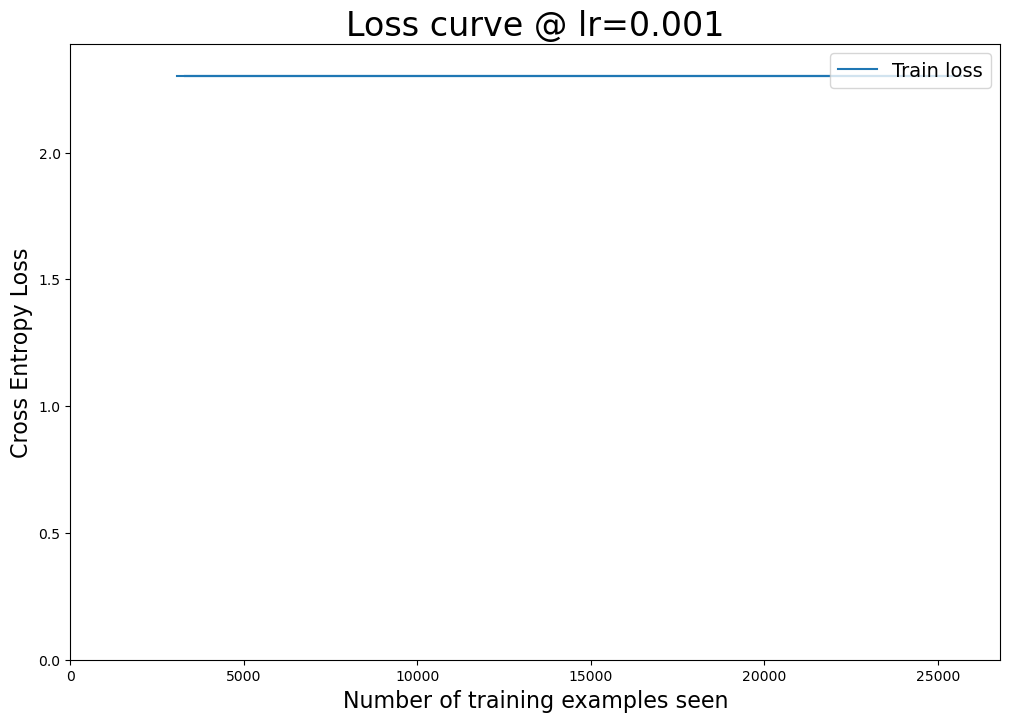

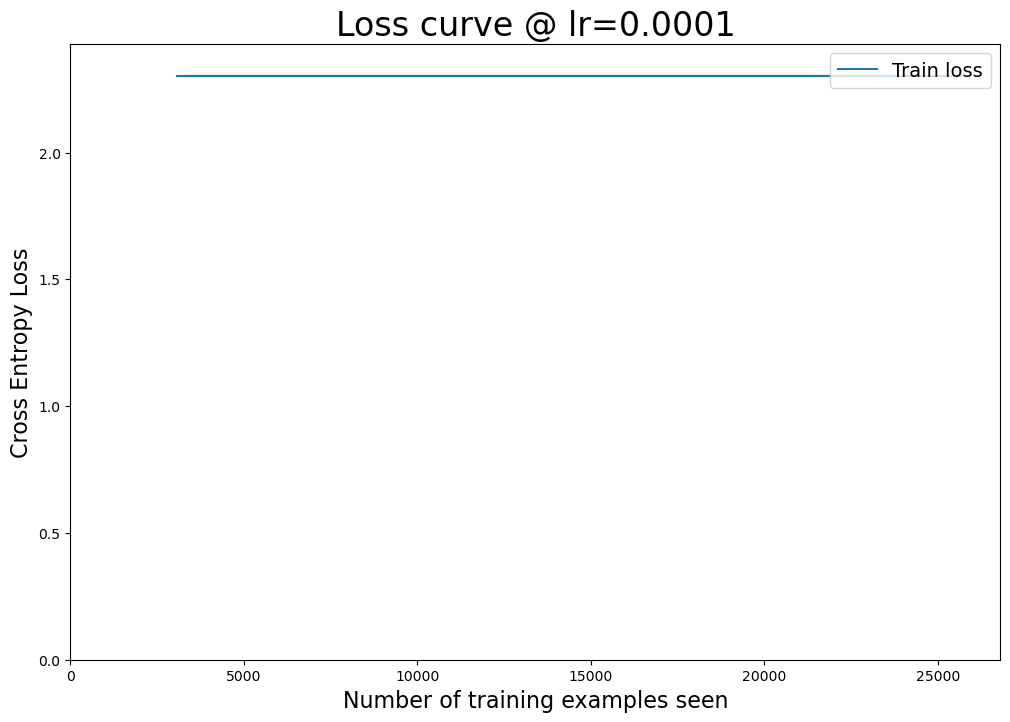

In [ ]:
for lr in lrs:
  print(results[lr])
  counter = results[lr][1]
  train_losses = results[lr][0]
  val_losses = results[lr][2]
  plot_losses(counter, train_losses, val_losses, lr)

As seen by the learning rate plots above, this kind of model does not seem to be able to learn from the data, likely because we would need a very large kernel size with a large dilation to be able to pick up on longer-term patterns that define the differences in genres. Because such an architecture would take too much computational power and time, we will move on to other convolutional models to see if simpler architectures can learn to classify audio more than this very complex one. 

# A Simpler Approach to Direct Audio Classification

In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# The first attempt at a 1d CNN
class AudioCNN1D(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, 5, dilation = 2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 32, 3)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()

        self.dense = nn.Linear(86501888, 10)
        self.relu4 = nn.ReLU()
        self.softmax = nn.LogSoftmax()


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        #x = self.conv3(x)
        #x = self.relu3(x)
            
        x = self.flatten(x)
        x = self.dense(x)
        x = self.relu4(x)
        x = self.softmax(x)

        return x

In [11]:
train_loader = audio_train_dl
val_loader = audio_val_dl


# Hyperparameters
lrs = [.01, 0.001, .0001]
max_epochs = 2
gamma = 0.95

# Recording data
log_interval = len(train_loader) / batch_size
def tune_model(lrs, n_epochs, train_loader=train_loader, val_loader=val_loader, gamma=gamma, type='spectrogram', num_channels=1, dilation_depth=2, num_repeat=1):
  model = AudioCNN1D()
      
  lr_dict = {}
  for lr in lrs:
      # Instantiate optimizer (model was created in previous cell)
      optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

      train_losses = []
      train_counter = []
      val_losses = []
      val_correct = []
      for epoch in trange(n_epochs, leave=True, desc='Epochs'):
          train_loss, counter = train_one_epoch(train_loader, model, DEVICE, optimizer, log_interval, epoch)
          val_loss, num_correct = test_one_epoch(val_loader, model, DEVICE)

          # Record results
          train_losses.extend(train_loss)
          train_counter.extend(counter)
          val_losses.append(val_loss)
          val_correct.append(num_correct)

      print(f"Val accuracy: {val_correct[-1]/len(val_loader.dataset)}")
      lr_dict[lr] = train_losses, train_counter, val_losses, val_correct
  return lr_dict

results = tune_model(lrs, max_epochs, type='wavenet', train_loader=audio_val_dl, val_loader=audio_val_dl, num_channels=1, num_repeat=2, dilation_depth=4)

NameError: ignored

In [12]:
def get_output_shape(model, image_dim):
    return model(torch.rand(*(image_dim))).data.shape
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# The Revised 1d CNN, with more flexibility for hyperparameter tuning
class CNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()

        self.n_layers = n_layers

        self.conv1 = nn.Conv1d(1, 8, 3)
        self.relu = nn.ReLU()
        self.pool1 = nn.AvgPool1d(2)

        self.conv2 = nn.Conv1d(8, 16, 3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool1d(2)

        self.conv3 = nn.Conv1d(16, 32, 3)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.AvgPool1d(2)

        self.flatten = nn.Flatten()

        
        self.dense = nn.Linear(2703200, 10)
        

        self.dense2 = nn.Linear(128, 10)
        self.relulast = nn.ReLU()
        self.relulast2 = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        if self.n_layers >=2:
            x = self.conv2(x)
            x = self.relu2(x)
            x = self.pool2(x)

        if self.n_layers >=3:
            x = self.conv3(x)
            x = self.relu3(x)
            x = self.pool3(x)
        
        x = self.flatten(x)

        x = self.dense(x)
        x = self.relulast(x)

        #x = self.dense2(x)
        #x = self.relulast2(x)

        x = self.softmax(x)

        return x

def define_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layers = []

    in_size = 1
    shape = len(audio_val[0][0])
    #model = AudioCNN1D(n_layers)

    # originally attempted to use sequential torch for this, but this led to some issues with matrix shapes when trying new numbers of layers
    # found it easier to define the model as a class, which allows for more flexibility in forward()
    '''
    for i in range(n_layers):
        #kernel_size = trial.suggest_categorical(f'kernel_size', [3, 5, 7, 9])
        out_size = trial.suggest_categorical(f'n_filters', [4, 8, 16, 32, 64, 128])
        layers.append(nn.Conv1d(in_size, out_size, 3))
        shape = shape * 3 * out_size
        layers.append(nn.ReLU())
        layers.append(nn.AvgPool1d(2))
        shape = int(shape/2)
        in_size = out_size
        print(shape)
        print(out_size)
        shape = 3 * shape * out_size

    #layers.append(nn.Flatten())

    layers.append(nn.Linear(shape, 10))
    layers.append(nn.ReLU())
    layers.append(nn.Softmax())

    model = nn.Sequential(*layers).to(DEVICE)
    '''
    model = CNN(2).to(DEVICE)
    return model

# using optuna's trial/objective framework for hyperparameter tuning
def objective(trial):
    model = define_model(trial)

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)

    train_loader = audio_val_dl
    val_loader = audio_val_dl

    max_epochs = trial.suggest_int('n_epochs', 5, 25, 5)

    for epoch in trange(max_epochs):
        #model.train()

        # Training
        for i, (wav, label) in enumerate(train_loader):
            
            wav = wav.to(DEVICE)
            label = label.to(DEVICE)
            #print(wav.shape)

            #print(wav.shape)
            optimizer.zero_grad()
            output = model(wav)
            output = torch.reshape(output, (1, 10))

            #print(label)
            #print(output)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        
        # Evaluation
        #model.eval()
        val_correct = 0

        with torch.no_grad():
            for batch_idx, (wav, label) in enumerate(val_loader):
                #print(wav.shape)
                wav = wav.to(DEVICE)
                label = label.to(DEVICE)

                output = model(wav)

                pred = output.argmax(dim=1, keepdim=True)
                label_idx = label.argmax(dim=1, keepdim=True)
                #print(pred)
                val_correct += pred.eq(label_idx).sum().item()

        accuracy = val_correct / len(val_loader)

        trial.report(accuracy, epoch)

    return accuracy




In [13]:
hp_tuning = optuna.create_study(direction='maximize')
hp_tuning.optimize(objective, n_trials=10, timeout=6000)

results = hp_tuning.get_trials(deepcopy=False)
best = hp_tuning.best_trial
print(f'Best Model:\nAccuracy(?):{best.value}')

for key, value in best.params.items():
    print(f"{key}: {value}")


[I 2023-04-27 18:57:29,210] A new study created in memory with name: no-name-c7ea5797-acc9-47e3-9622-940fe7f641a7
100%|██████████| 15/15 [03:02<00:00, 12.14s/it]
[I 2023-04-27 19:00:35,043] Trial 0 finished with value: 0.1 and parameters: {'n_layers': 3, 'optimizer': 'SGD', 'lr': 0.06085632159961745, 'n_epochs': 15}. Best is trial 0 with value: 0.1.
100%|██████████| 15/15 [01:10<00:00,  4.72s/it]
[I 2023-04-27 19:01:46,110] Trial 1 finished with value: 0.1 and parameters: {'n_layers': 3, 'optimizer': 'SGD', 'lr': 0.013565913571434166, 'n_epochs': 15}. Best is trial 0 with value: 0.1.
100%|██████████| 25/25 [01:57<00:00,  4.72s/it]
[I 2023-04-27 19:03:44,544] Trial 2 finished with value: 0.1 and parameters: {'n_layers': 3, 'optimizer': 'SGD', 'lr': 0.039211533523017386, 'n_epochs': 25}. Best is trial 0 with value: 0.1.
100%|██████████| 15/15 [01:10<00:00,  4.68s/it]
[I 2023-04-27 19:04:55,030] Trial 3 finished with value: 0.24 and parameters: {'n_layers': 1, 'optimizer': 'SGD', 'lr': 0.

Best Model:
Accuracy(?):0.24
n_layers: 1
optimizer: SGD
lr: 0.0021278868104712754
n_epochs: 15


Above, we see that the best verison of our 1d CNN attained a test accuracy of 0.24, much worse than the spectrogram model, but better than random guessing and better than the WaveNet